## Creación cartera hedge a partir de un modelo RNN de estimación de alphas residuales

En este notebook se va a generar la equity de las carteras estimadas a partir del mejor modelo RNN generado en el notebook anterior en el periodo de test [2019:2024].

Para ello se rolará desde el 2019 año a año los periodos anuales, en cada periodo anual se creará el dataset de test de los cinco años anteriores para todos los activos, para que se estimen los alphas residuales de cada activo en el año actual, y se seleccionen los tres activos con mejor alpha residual.

Una vez completados todos los periodos de test anuales, se procederá a comparar la equity de la cartera dinámica generada con la equity del SPY.



In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf
import requests

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, BatchNormalization, MaxPooling1D, Attention
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error
from joblib import dump, load

%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

from modulos.tfm_util import metrica_cartera
from modulos.tfm_util import drwdown
from modulos.tfm_util import desnorm_zscore01
from modulos.tfm_util import norm_zscore01

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Cargar señal, datos, alphas y alphas relativos a SPY

Se cargan los datos, y se crean los conjuntos de test de alphas y alphas residuales

In [12]:
datos_vixsi = pd.read_csv ("../datos/vixsi.csv", index_col = 0)
datos_vixsi.index = pd.to_datetime(datos_vixsi.index)

data = pd.read_csv("../datos/sp500.csv", index_col=0)
data.index = pd.to_datetime(data.index)

indices = list(set(data.index) & set(datos_vixsi.index))
data = data.loc[indices]
data.sort_index(inplace=True)

#solo interesan los retornos
data = data.pct_change()

df_alpha = pd.read_csv("../datos/alphas_ann.csv", index_col=0)
df_alpha_res = df_alpha.sub(df_alpha.SPY, axis=0)
df_alpha = df_alpha.drop(columns = "SPY")
df_alpha_res = df_alpha_res[df_alpha.columns]

# Se incluye la señal desplazada, cargada al inicio del notebook
data["vixsignal"] = datos_vixsi.VIXSI.shift(1)


### Se carga el modelo RNN creado en el notebook anterior 

In [13]:
dalphas_RNN = load("dalphas_RNN.mdl")
tam_grupo = dalphas_RNN["tam_grupo"]
media = dalphas_RNN["media"]
std_dev = dalphas_RNN["std_dev"]
array_min = dalphas_RNN["array_min"]
array_max = dalphas_RNN["array_max"]
modelo_dalphas = dalphas_RNN["modelo"]



### Generación de la cartera

Para cada periodo de 1 año, rolando cada año desde el 2019 al 2024:

    1. Se crea el dataset de características con los alphas relativos, utilizando los cinco años anteriores y se normaliza

    2. Se normalizan las caraceristicas y predice la salida normalizada, que representa la estimación del alpha relativo actual.

    3. Se seleccionarán los cinco activos (metaparámetro fijo) con mayor alpha relativo.

    4. Se filtran la mitad de los activos con mayor Beta.

    5. Se calculan los rendimientos de la estrategia en el periodo de test actual.




In [14]:
def crear_agrupacion_X (datos_res, datos, tam_grupo):
    '''
    Se crean las agrupaciones, solo incluyendo los atributos,
    no el valor a predecir.
    
    Se añaden los activos para localizar el activo que corresponde a la iésima fila
    
    
    Devuelve la matriz de agrupaciones y los activos para indexarla 
    
    '''

    tam_grupoX = tam_grupo - 1
    num_activos = len(datos.columns)
    agrup = np.zeros((num_activos,tam_grupoX,2))
    activos = []

    for a in range(num_activos):
        activo = datos.columns[a]
        if datos.iloc[:tam_grupo][activo].sum() == 0:
            continue
        agrup[a,:,0] = datos_res.iloc[:tam_grupoX][activo]
        agrup[a,:,1] = datos.iloc[:tam_grupoX][activo]
        activos.append(activo)

    return agrup, activos

desde_test = 2019
hasta_test = 2024

# Se inicializan valores de la estrategia
data["VIXSIhedge"] = 0
data["VIXSI"] = 0
#data["vixsignal"] = datos.vixsignal.shift(1)
ret_estrategias = ["VIXSIhedge","VIXSI"]

for i in range(hasta_test - desde_test + 1):
    
    max_rdv = -999
    max_k = -1
    max_fsel = None
    max_activos = []

    desde_5 = str(desde_test + i-5)
    hasta_5 = str(desde_test + i-1)
    alpha_res_ts = df_alpha_res.loc[desde_5:hasta_5]
    alpha_ts = df_alpha.loc[desde_5:hasta_5]
    # Crea el grupo de las X's (características)
    alphagr_ts, activos_ts = crear_agrupacion_X (alpha_res_ts, alpha_ts, tam_grupo)
    # Si hay activos sin precios en cinco o más años, se filtran y se vuelve a generar la agrupación
    # para alinear el índice de los activos con el índice de las características
    if len(activos_ts) != len(alpha_ts.columns):
        alphagr_ts, activos_ts = crear_agrupacion_X (alpha_res_ts[activos_ts], alpha_ts[activos_ts], tam_grupo)

    # normaliza las caraceristicas, predice la salida normalizada (que serían los alphas relativos actuales)
    XX_ts = norm_zscore01(alphagr_ts, media, std_dev, array_min, array_max)
    Yt_pred = modelo_dalphas.predict(XX_ts, verbose=0)
    # desnormaliza la salida (que está entrenada de manera normalizada)
    Yt_pred = desnorm_zscore01(Yt_pred, media, std_dev, array_min, array_max)
    
    # A partir de los alphas relativos estimados, selecciona los tres de mayor valor
    df_pred = pd.DataFrame(Yt_pred, index=activos_ts)
    df_pred.columns = ["alphares_pred"]
    max_activos = list(df_pred.sort_values(by="alphares_pred", ascending=False).iloc[:2].index)

    
    spy = data.loc[desde_5:hasta_5].dropna().SPY.values
    cartera = data.loc[desde_5:hasta_5, max_activos].dropna().values
    covs = np.cov(cartera.T, spy)[-1, :-1]
    varspy = np.var(spy)
    betas = list(covs / varspy)
    pos = int(len(max_activos)/2)
    max_activos_beta = pd.DataFrame(betas, index=max_activos).sort_values(0, ascending=False)[:pos].index.to_list()
    max_activos = max_activos_beta


    # Calcula los rendimientos del periodo de test actual con los activos seleccionados
    desde_actual = str(desde_test + i)
    hasta_actual = str(desde_test + i)
    retornos = np.array (data.loc[desde_actual:hasta_actual,max_activos])
    señal_corto = np.array ((data.loc[desde_actual:hasta_actual].vixsignal-1)/2).reshape(-1,1)
    vixsimixto_corto = (retornos * señal_corto * 1/len(max_activos)).sum(axis=1)
    vixsimixto_largo = np.array((data.loc[desde_actual:hasta_actual].vixsignal+1)/2 * data.loc[desde_actual:hasta_actual].SPY)

    vixsimixto = vixsimixto_corto + vixsimixto_largo

    data.loc[desde_actual:hasta_actual,ret_estrategias[0]] = pd.DataFrame(pd.Series(vixsimixto)).set_index(
                                                    data.loc[desde_actual:hasta_actual].index)[0]
    data.loc[desde_actual:hasta_actual,ret_estrategias[1]] = (data.loc[desde_actual:hasta_actual].vixsignal *
                                                    data.loc[desde_actual:hasta_actual].SPY)


### Test de la cartera

Comparación del alpha de la cartera combinada con el alpha del SPY periodo 2019 en adelante

,RetAnual,RSharpe,MaxDwd
ESTR_VIXSIhedge,0.25,0.96,0.21
ESTR_VIXSI,0.33,1.44,0.19


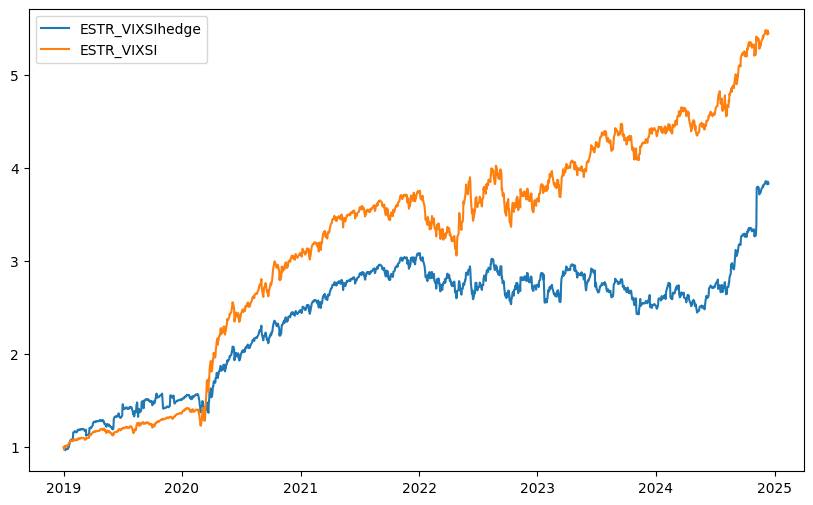

In [15]:
estrategias = ["ESTR_"+ret_estrategia for ret_estrategia in ret_estrategias]
data[estrategias] = (1 + data[ret_estrategias]).cumprod()

tdatos = data.loc["2019":,estrategias]
tdatos[estrategias] = tdatos[estrategias]/tdatos[estrategias].iloc[0]
#tdatos["VIXSIMIXCART"] = tdatos.VIXSIMIXCART/tdatos.VIXSIMIXCART.iloc[0]
#tdatos["VIXSISPY"] = tdatos.VIXSISPY/tdatos.VIXSISPY.iloc[0]

ret_ann, ret_ann_b, r_sharpe, r_sharpe_b = metrica_cartera(tdatos[estrategias[0]], tdatos[estrategias[1]])
maxdwn, *_ = drwdown (tdatos[estrategias[0]])
maxdwn_b, *_ = drwdown (tdatos[estrategias[1]])

valores = [[ret_ann, r_sharpe, maxdwn], [ret_ann_b, r_sharpe_b, maxdwn_b]]
df_result = pd.DataFrame(valores, index= estrategias)
df_result.columns = ["RetAnual","RSharpe","MaxDwd"]

plt.figure(figsize=(10,6))
plt.plot(tdatos[estrategias[0]], label=estrategias[0])
plt.plot(tdatos[estrategias[1]], label=estrategias[1])

plt.legend()
plt.plot()
plt.savefig('vixsi_rnn.png')

df_result = df_result.round(2)
df_result.to_clipboard()
df_result

### Conclusiones

Se puede ver que la estrategia VIXSIhedge con Los activos seleccionados por el modelo RNN tiene un comportamiento peor que el la estrategia VIXSI.
